Initial shape: (18468, 18)
Initial columns: ['video_id', 'video_published_timestamp', 'channel_id', 'channel_name', 'creator_type_id', 'video_length', 'views_final', 'impressions_final', 'like_final', 'comment_final', 'views3s_1k', 'impressions_1k', 'like_1k', 'comments_1k', 'views3s_5k', 'impressions_5k', 'like_5k', 'comments_5k']


/var/folders/db/wvxvqb3n1x3g3lw6rkhn8zxh0000gn/T/ipykernel_74134/1933181001.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['video_published_timestamp'] = pd.to_datetime(df['video_published_timestamp'], errors='coerce')


After feature eng, columns are: ['video_id', 'channel_id', 'channel_name', 'video_length', 'views_final', 'views3s_1k', 'impressions_1k', 'like_1k', 'comments_1k', 'views3s_5k', 'impressions_5k', 'like_5k', 'comments_5k', 'publish_hour', 'publish_weekday', 'publish_dayofyear', 'ctr_1k', 'like_per_view_1k', 'comment_per_view_1k', 'has_5k_data', 'ctr_5k', 'like_per_view_5k', 'comment_per_view_5k', 'view_growth_rate', 'impression_growth_rate', 'video_length_bin_short', 'video_length_bin_medium', 'video_length_bin_long', 'video_length_bin_very_long', 'creator_type_id_CP Medium', 'creator_type_id_CP Standard', 'creator_type_id_JSO']
Lifetime class distribution: lifetime_class
0    4943
3    3604
4    3496
2    3220
1    3205
Name: count, dtype: int64
Dropping non-numeric column 'channel_name'
LC=0, best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
LC=4, best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
LC=2, best params: {'learning_rate': 0.1, 

/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.wa


Test MAPE on original scale: 7.8006 (i.e. 780.06%)
Test R^2 on original scale : 0.0856


/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/Users/adviti/code/advitis/video-performance-predictor/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.wa

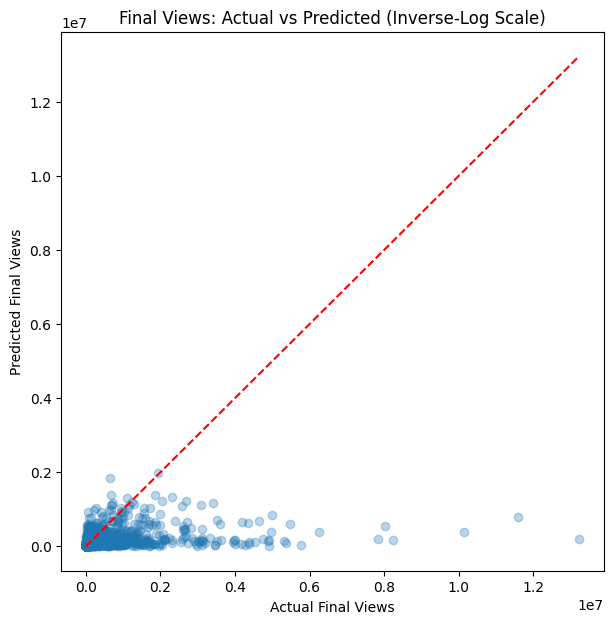

In [1]:
#######################################################################
# A SINGLE-CELL NOTEBOOK EXAMPLE FOR VIDEO POPULARITY PREDICTION
# USING MILESTONE FEATURES, LIFETIME CLASSES, AND LOG-TRANSFORMED TARGET
#######################################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# 1. LOAD DATA
df = pd.read_csv("../data/Initial Engagement v1 - _WITH_videos_AS_get_the_videos_.csv")  # Adjust path if needed
print("Initial shape:", df.shape)
print("Initial columns:", df.columns.tolist())

# 2. HANDLE TIMESTAMP COLUMNS (IF ANY)
if 'video_published_timestamp' in df.columns:
    df['video_published_timestamp'] = pd.to_datetime(df['video_published_timestamp'], errors='coerce')
    # Example: extract numeric features from the timestamp
    df['publish_hour'] = df['video_published_timestamp'].dt.hour
    df['publish_weekday'] = df['video_published_timestamp'].dt.weekday
    df['publish_dayofyear'] = df['video_published_timestamp'].dt.dayofyear
    # Drop original string column
    df.drop('video_published_timestamp', axis=1, inplace=True)

# 3. DROP ANY *_final COLUMNS EXCEPT 'views_final'
drop_cols = []
for col in df.columns:
    if col.endswith('_final') and col != 'views_final':
        drop_cols.append(col)
if drop_cols:
    df.drop(columns=drop_cols, inplace=True)

# 4. FEATURE ENGINEERING
# - Replace 0 with NaN for certain columns to avoid /0
for c in ['impressions_1k','views3s_1k']:
    if c in df.columns:
        df[c] = df[c].replace(0, np.nan)

# - Basic 1K features
if 'impressions_1k' in df.columns and 'views3s_1k' in df.columns:
    df['ctr_1k'] = df['views3s_1k'] / df['impressions_1k']
    df['like_per_view_1k'] = df['like_1k'] / df['views3s_1k'].replace(0, np.nan)
    df['comment_per_view_1k'] = df['comments_1k'] / df['views3s_1k'].replace(0, np.nan)

# - Mark 5k data
df['has_5k_data'] = (
    (~df.get('views3s_5k', pd.Series()).isna()) &
    (~df.get('impressions_5k', pd.Series()).isna())
).astype(int)

mask_5k = (df['has_5k_data'] == 1)
if mask_5k.sum() > 0:
    df.loc[mask_5k, 'ctr_5k'] = df.loc[mask_5k, 'views3s_5k'] / df.loc[mask_5k, 'impressions_5k'].replace(0, np.nan)
    df.loc[mask_5k, 'like_per_view_5k'] = df.loc[mask_5k, 'like_5k'] / df.loc[mask_5k, 'views3s_5k'].replace(0, np.nan)
    df.loc[mask_5k, 'comment_per_view_5k'] = df.loc[mask_5k, 'comments_5k'] / df.loc[mask_5k, 'views3s_5k'].replace(0, np.nan)
    df.loc[mask_5k, 'view_growth_rate'] = (
        df.loc[mask_5k, 'views3s_5k'] - df.loc[mask_5k, 'views3s_1k']
    ) / df.loc[mask_5k, 'views3s_1k'].replace(0, np.nan)
    df.loc[mask_5k, 'impression_growth_rate'] = (
        df.loc[mask_5k, 'impressions_5k'] - df.loc[mask_5k, 'impressions_1k']
    ) / df.loc[mask_5k, 'impressions_1k'].replace(0, np.nan)

# - Bin video_length if present
if 'video_length' in df.columns:
    df['video_length_bin'] = pd.cut(df['video_length'],
                                    bins=[0, 60, 180, 300, 600, np.inf],
                                    labels=['very_short','short','medium','long','very_long'])
    df = pd.get_dummies(df, columns=['video_length_bin'], drop_first=True)

# - One-hot encode a 'creator_type_id' or similar categorical if present
if 'creator_type_id' in df.columns:
    df = pd.get_dummies(df, columns=['creator_type_id'], drop_first=True)

# Fill leftover NaN
df = df.fillna(0)
print("After feature eng, columns are:", df.columns.tolist())

# 5. DEFINE LIFETIME CLASS
df['lifetime_class'] = 0
mask_5k_data = (df['has_5k_data'] == 1) & (df.get('view_growth_rate', 0) != 0)
df_5k_only = df.loc[mask_5k_data].copy()

if len(df_5k_only) > 0:
    df_5k_only['lifetime_class'] = pd.qcut(df_5k_only['view_growth_rate'], q=4, labels=[1,2,3,4]).astype(int)
    df.loc[mask_5k_data, 'lifetime_class'] = df_5k_only['lifetime_class']

mask_1k_only = (df['has_5k_data'] == 0)
if mask_1k_only.sum() > 0 and len(df_5k_only) > 0:
    feats_classif = ['ctr_1k','like_per_view_1k','comment_per_view_1k']
    df_train_cls = df_5k_only.dropna(subset=feats_classif + ['lifetime_class'])
    X_train_cls = df_train_cls[feats_classif]
    y_train_cls = df_train_cls['lifetime_class']
    cls_model = RandomForestClassifier(n_estimators=50, random_state=42)
    cls_model.fit(X_train_cls, y_train_cls)

    df_1k_only = df.loc[mask_1k_only].copy()
    X_pred_cls = df_1k_only[feats_classif]
    pred_lc = cls_model.predict(X_pred_cls)
    df.loc[mask_1k_only, 'lifetime_class'] = pred_lc

print("Lifetime class distribution:", df['lifetime_class'].value_counts())

# 6. LOG-TRANSFORM THE TARGET
target_col = "views_final"
if target_col not in df.columns:
    raise ValueError("views_final not found. Please adjust your target name.")
df['views_final_log'] = np.log1p(df[target_col])  # log(1 + views_final)

# 7. PREPARE DATA (ONLY NUMERIC COLUMNS), EXCLUDE ID + LIFETIME_CLASS + RAW VIEWS_FINAL
excluded_cols = ["video_id","lifetime_class", target_col]
feature_cols = [c for c in df.columns if c not in excluded_cols and c != "views_final_log"]

X_full = df[feature_cols].copy()
y_full = df["views_final_log"]   # we'll train on the LOG target
lc_full = df["lifetime_class"]

# Drop or convert any non-numeric columns
for col in X_full.columns:
    if X_full[col].dtype == 'object':
        print(f"Dropping non-numeric column '{col}'")
        X_full.drop(col, axis=1, inplace=True)

# 8. TRAIN/TEST SPLIT
X_train, X_test, y_train, y_test, lc_train, lc_test = train_test_split(
    X_full, y_full, lc_full, test_size=0.2, random_state=42
)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
}

# 9. TRAIN SPECIALIZED MODELS
from sklearn.model_selection import GridSearchCV

specialized_models = {}
unique_lcs = lc_train.unique()

for lc in unique_lcs:
    mask_lc = (lc_train == lc)
    if mask_lc.sum() < 10:
        # Quick fallback if not enough data
        m = GradientBoostingRegressor(random_state=42)
        m.fit(X_train[mask_lc], y_train[mask_lc])
        specialized_models[lc] = m
        continue

    base_model = GradientBoostingRegressor(random_state=42)
    gs = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=3,
        n_jobs=-1,
        scoring='neg_mean_absolute_percentage_error'
    )
    gs.fit(X_train[mask_lc], y_train[mask_lc])
    specialized_models[lc] = gs.best_estimator_
    print(f"LC={lc}, best params: {gs.best_params_}")

# Fallback model on entire training set
fallback_model = GradientBoostingRegressor(random_state=42)
fallback_model.fit(X_train, y_train)
specialized_models["fallback"] = fallback_model

# 10. PREDICT ON TEST SET (INVERSE LOG)
y_pred_log = np.zeros(len(X_test))
for i, idx in enumerate(X_test.index):
    this_lc = lc_test.loc[idx]
    model = specialized_models[this_lc] if this_lc in specialized_models else specialized_models["fallback"]
    row_feats = X_test.loc[idx].values.reshape(1, -1)
    y_pred_log[i] = model.predict(row_feats)[0]

# Convert predictions back to original scale
y_pred = np.expm1(y_pred_log)          # inverse of log1p
y_test_exp = np.expm1(y_test.values)   # also invert test data for metrics

mape = mean_absolute_percentage_error(y_test_exp, y_pred)
r2 = r2_score(y_test_exp, y_pred)

print(f"\nTest MAPE on original scale: {mape:.4f} (i.e. {mape*100:.2f}%)")
print(f"Test R^2 on original scale : {r2:.4f}")

# 11. PLOT
plt.figure(figsize=(7,7))
plt.scatter(y_test_exp, y_pred, alpha=0.3)
plt.plot([y_test_exp.min(), y_test_exp.max()],[y_test_exp.min(), y_test_exp.max()], 'r--')
plt.title("Final Views: Actual vs Predicted (Inverse-Log Scale)")
plt.xlabel("Actual Final Views")
plt.ylabel("Predicted Final Views")
plt.show()